In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
% matplotlib inline

In [71]:
random_seed = 42

## Utility function to drop duplicate columns

In [22]:
from pandas.core.common import array_equivalent

def remove_duplicate_cols(df):
    """http://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
    
    Use like:
    df = remove_duplicate_cols(df)
    
    If no duplicates, we return gracefully
    """
    Cols = list(df.columns)
    for i,item in enumerate(df.columns):
        if item in df.columns[:i]: Cols[i] = "toDROP"
    df.columns = Cols
    drop_cols = len([col for col in list(df.columns) if col == 'toDROP'])
    if drop_cols:
        return df.drop("toDROP", axis=1)
    else:
        return df

In [2]:
ls data/ipu_data

dal_ipu_dev.csv     ipus_test.csv       is13_ipu_train.csv  neo_ipu_dev.csv
dal_ipu_test.csv    ipus_train.csv      liwc_ipu_dev.csv    neo_ipu_test.csv
dal_ipu_train.csv   is13_ipu_dev.csv    liwc_ipu_test.csv   neo_ipu_train.csv
ipus_dev.csv        is13_ipu_test.csv   liwc_ipu_train.csv


## Read in and Format the data

In [12]:
dal = {'train':pd.read_csv('data/ipu_data/dal_ipu_train.csv'),
       'dev':pd.read_csv('data/ipu_data/dal_ipu_dev.csv'),
       'test':pd.read_csv('data/ipu_data/dal_ipu_test.csv')}
dal['train'].head(1)

,ipu,name,FunctionalWordPercent,mean_pleaseant,max_pleaseant,min_pleaseant,median_pleaseant,std_pleaseant,var_pleaseant,mean_activate,...,std_activate,var_activate,mean_imagery,max_imagery,min_imagery,median_imagery,std_imagery,var_imagery,label,pid
0,0,p204p205-part1_ch1_1,0.745394,0.97547,0.60882,1.332385,0.98107,-0.953187,-0.683007,0.593455,...,-0.951077,-0.670512,0.181267,-0.229756,0.617142,0.246986,-0.857853,-0.645889,0,205


In [27]:
is13 = {'train':pd.read_csv('data/ipu_data/is13_ipu_train.csv'),
       'dev':pd.read_csv('data/ipu_data/is13_ipu_dev.csv'),
       'test':pd.read_csv('data/ipu_data/is13_ipu_test.csv')}

In [4]:
liwc = {'train':pd.read_csv('data/ipu_data/liwc_ipu_train.csv'),
       'dev':pd.read_csv('data/ipu_data/liwc_ipu_dev.csv'),
       'test':pd.read_csv('data/ipu_data/liwc_ipu_test.csv')}

In [5]:
neo = {'train':pd.read_csv('data/ipu_data/neo_ipu_train.csv'),
       'dev':pd.read_csv('data/ipu_data/neo_ipu_dev.csv'),
       'test':pd.read_csv('data/ipu_data/neo_ipu_test.csv')}

In [6]:
ipu = {'train':pd.read_csv('data/ipu_data/ipus_train.csv'),
       'dev':pd.read_csv('data/ipu_data/ipus_dev.csv'),
       'test':pd.read_csv('data/ipu_data/ipus_test.csv')}

In [26]:
ipu['train'].shape, dal['train'].shape, liwc['train'].shape, neo['train'].shape

((19390, 7), (19390, 23), (19390, 134), (19390, 9))

In [28]:
# combine all the data
all_train = pd.concat([ipu['train'], neo['train'], liwc['train'], dal['train'], is13['train']], axis=1)
all_dev = pd.concat([ipu['dev'], neo['dev'], liwc['dev'], dal['dev'], is13['dev']], axis=1)
all_test = pd.concat([ipu['test'], neo['test'], liwc['test'], dal['test'], is13['test']], axis=1)

# drop columns duplicated across feature sets
all_train = remove_duplicate_cols(all_train)
all_dev = remove_duplicate_cols(all_dev)
all_test = remove_duplicate_cols(all_test)

# index by person by ipu
all_train = all_train.set_index(['pid', 'ipu'])
all_dev = all_dev.set_index(['pid', 'ipu'])
all_test = all_test.set_index(['pid', 'ipu'])

# drop columns that aren't covariates or labels
useless_cols = ['Unnamed: 0', 'fname', 'name', 'start', 'end']
all_train = all_train.drop(useless_cols, axis=1)
all_dev = all_dev.drop(useless_cols, axis=1)
all_test = all_test.drop(useless_cols, axis=1)

In [39]:
all_train.shape, all_dev.shape, all_test.shape

((19390, 6531), (12386, 6531), (23766, 6531))

In [52]:
# combine the training and dev datasets
all_train = pd.concat([all_train, all_dev])

In [77]:
# fill in the random NaNs with 0, since working with standardized columns
all_train = all_train.fillna(0.0)
all_dev = all_dev.fillna(0.0)
all_test = all_test.fillna(0.0)

In [86]:
all_train.isnull().any().any()

False

In [85]:
all_test.isnull().any().any()

False

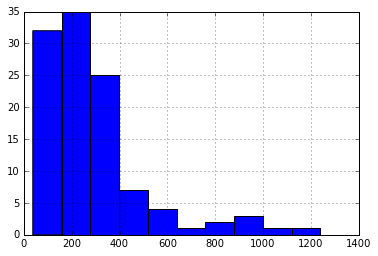

In [78]:
# number of ipus by pid
all_train.groupby(level=0).count()['text'].hist()

In [79]:
# label baselines for train and test
t, f = all_train['label'].value_counts()
train_base = max([t,f])/float(sum([t,f]))
print "Training baseline: %2.4f" % train_base

t, f = all_test['label'].value_counts()
test_base = max([t,f])/float(sum([t,f]))
print "Test baseline: %2.4f" % test_base

class_names = ['Not Deceptive', 'Deceptive'] # 0 is truth, 1 is lie

Training baseline: 0.6212
Test baseline: 0.5904


In [80]:
all_train.head(1)

,,text,label,Gender,Language,Nscore_raw,Escore_raw,Oscore_raw,Ascore_raw,Cscore_raw,LIWC_funct_funcword,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
pid,ipu,,,,,,,,,,,,,,,,,,,,,
205,0,i,0,0.0,1.0,0.836309,-1.427222,-0.880482,-0.267426,-1.479525,1.37892,...,-0.234093,1.088132,-0.039729,-0.313299,0.041875,-3.337331,-1.775955,-1.450182,-1.331211,-0.984684


In [81]:
noncovariates = ['label', 'text']
train_x = all_train.drop(noncovariates, axis=1).as_matrix()
train_y = all_train['label'].as_matrix()
test_x = all_test.drop(noncovariates, axis=1).as_matrix()
test_y = all_test['label'].as_matrix()

In [88]:
np.any(np.isnan(train_x)), np.any(np.isnan(train_y))

(False, False)

In [89]:
np.any(np.isnan(test_x)), np.any(np.isnan(test_y))

(False, False)

In [90]:
def experiment(clf, param_grid, grid_metric='accuracy',
               train_x=train_x, train_y=train_y, 
               test_x=test_x, test_y=test_y, 
               label_names=class_names, cv=10):
    """Run GridSearchCv on the pipeline `clf` with `cv` number of folds over `grid`
    
    Then refit the best parameters on all of the train data, and analyze the test performance
    
    Performance metrics: accuracy, f1-score for Deceptive, confusion matrix
    
    NOTE: Specify parallel jobs in clf.  Won't do grid search in parallel.
    """
    print "Searching Grid..."
    grid = GridSearchCV(clf, param_grid, grid_metric, cv=cv, verbose=1)
    grid.fit(train_x, train_y)
    print "Fitting best estimator..."
    print "Chosen parameters: \n", grid.best_params_
    print "Best Estimator: \n", grid.best_estimator_
    clf.set_params(**grid.best_params_)
    clf.fit(train_x, train_y)
    print "Evaluating on Test..."
    preds = clf.predict(test_x)
    acc = accuracy_score(test_y, preds)
    p = precision_score(test_y, preds)
    r = recall_score(test_y, preds)
    f1 = f1_score(test_y, preds)
    print "Test Accuracy: %1.4f, Test F1: %1.4f (P:%0.2f R:%0.2f)" % (acc, f1, p, r)
    confusion_matrix = cm(test_y, preds)
    results = {'clf': clf,
               'best_params':grid.best_params_,
               'grid_scores':grid.grid_scores_,
               'acc':acc,
               'f1':f1, 'precision':p, 'recall':r,
               'cm':confusion_matrix}
    return results

def plot_confusion_matrix(cm, label_names=class_names, save_name=None, 
                          title='Normed Confusion matrix', 
                          cmap=plt.cm.Blues, 
                          stats=None):
    """Take confusion matrix, label names and plot a very nice looking confusion matrix
    Args:
        cm: a confustion matrix w/ prediction rows and true columns
        label_names: list of class names for tick labels
        save_name (optional): if provided, save the figure to this location
        title (optional): the desired title
        cmap (optional): the colormap to display cell magnitudes with
        stats (optional): if stats, label class precisions and macro stats
    """
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calc normalized cm
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > .5 else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, fontsize=14)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', origin='upper', cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # set ticks and offset grid
    tick_marks = np.arange(len(label_names))
    tick_marks_offset = np.arange(len(label_names)) - .5
    ax.set_xticks(tick_marks, minor=False)
    ax.set_yticks(tick_marks, minor=False)
    ax.set_xticks(tick_marks_offset, minor=True)
    ax.set_yticks(tick_marks_offset, minor=True)
    ax.grid(which='minor')
    if stats:
        # include micro precisio, recall, and f1
        aug_y_labels = []
        for i in range(len(label_names)):
            aug = ("%s\nP:%0.2f, R:%0.2f, F1:%0.2f" 
                   % (label_names[i],
                      stats['class_precision'][i],
                      stats['class_recall'][i],
                      stats['class_f1'][i],))
            aug_y_labels.append(aug)
    else:
        aug_y_labels = label_names
    ax.set_xticklabels(label_names, horizontalalignment='left')
    ax.set_yticklabels(aug_y_labels)
    
    # other stuff
    plt.tight_layout()
    plt.ylabel('Predicted Labels', fontsize=16)
    if stats:
        # include macro 
        aug_x_label = ("True Labels\n Micro P:%0.2f, R:%0.2f, F1:%0.2f\n Macro P:%0.2f, R:%0.2f, F1:%0.2f" 
                       % (stats['micro_precision'], stats['micro_recall'], stats['micro_f1'],
                          stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    else:
        aug_x_label = "True Label"
    plt.xlabel(aug_x_label, fontsize=16)
    plt.title(title, fontsize=18)
    if save_name:
        plt.savefig(save_name+'.pdf')
        
def plot_grid_scores(grid_scores, baseline=train_base):
    """Take grid scores and plot interactive box and whisker plot with baseline reference"""
    # determine endpoint of baseline
    cv_scores = [s[2] for s in grid_scores] # 2 is cross val scores
    labels = ["\n".join([str(val) for val in s[0].values()]) for s in grid_scores]
    x_label = ", ".join([str(key) for key in grid_scores[0][0].keys()])
    fig, ax = plt.subplots(figsize=(15,6))
    boxes = ax.boxplot(cv_scores)
    ax.hlines([baseline], [0], [len(grid_scores) + 1], linestyles='dashed', label='Baseline Accuracy')
    
    plt.legend(loc='best')
    ax.set_title("Cross Validation Scores")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_xticklabels(labels, fontsize=8)
    plt.show()

In [91]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report as report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as cm

# Random Forest w/o pre-feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid =dict(n_estimators=[5, 10, 50, 100, 200, 300], 
                 criterion=['entropy'],
                 max_features=['log2', 'sqrt']
#                  max_depth=None, 
#                  min_samples_split=2, 
#                  min_samples_leaf=1, 
#                  min_weight_fraction_leaf=0.0, 
#                  max_features='auto', 
#                  max_leaf_nodes=None, 
#                  bootstrap=True, 
#                  oob_score=False, 
#                  n_jobs=1, 
#                  random_state=None, 
#                  verbose=0, 
#                  warm_start=False, 
#                  class_weight=None
                )
rf_results = experiment(rf, param_grid)

Searching Grid...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 16.5min
